In [ ]:
from ultralytics import SAM
# Load a model
model = SAM("sam_b.pt")


0: 384x640 6 potholes, 51.4ms
Speed: 3.1ms preprocess, 51.4ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


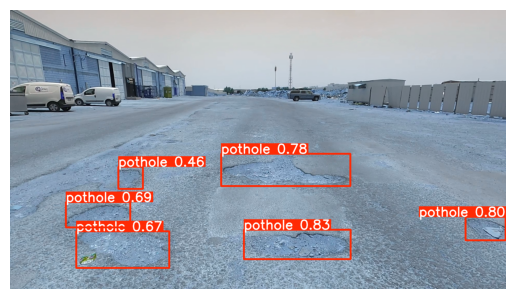

In [43]:
from ultralytics import YOLO
import cv2
pothole_model = YOLO('best.pt')# Our Object detection model for pothole detection (bounding box detection)
img=cv2.imread('road.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
results_pothole = pothole_model(img,iou=0.3,conf=0.3)

annotated_image = results_pothole[0].plot()
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

In [47]:
bb=results_pothole[0].boxes.xyxy.data.cpu().numpy()


image 1/1 C:\Users\tksen\Desktop\yolo_seg\road.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 620.8ms
Speed: 15.9ms preprocess, 620.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)


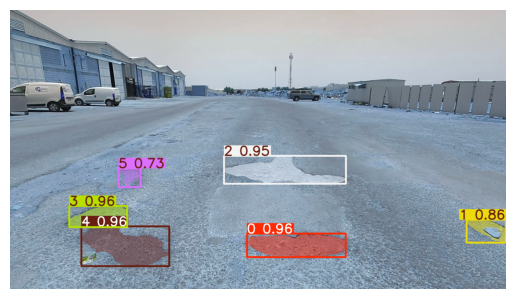

In [49]:
results = model("road.jpg", bboxes=bb)
annotated_image = results[0].plot()
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

In [53]:
m1=results[0].masks
mask=m1.data.cpu().numpy()

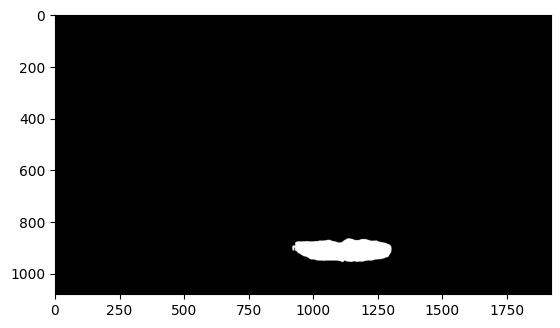

Pothhole Area: 26734 in pixels


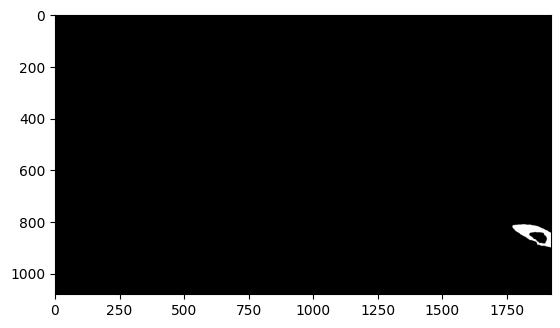

Pothhole Area: 5943 in pixels


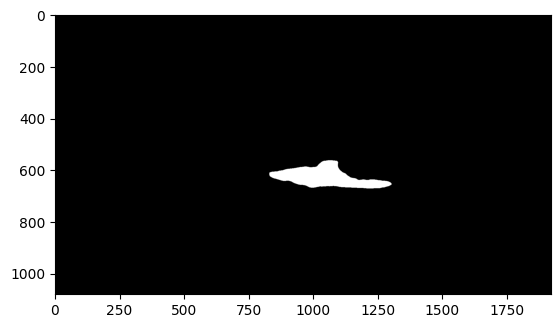

Pothhole Area: 25290 in pixels


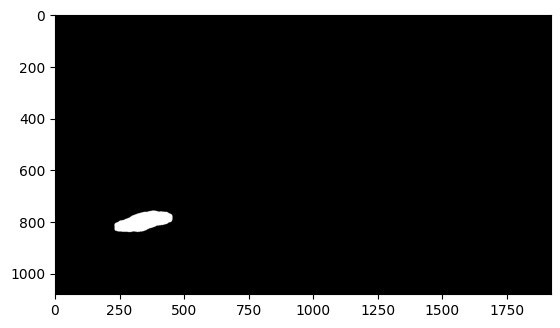

Pothhole Area: 12309 in pixels


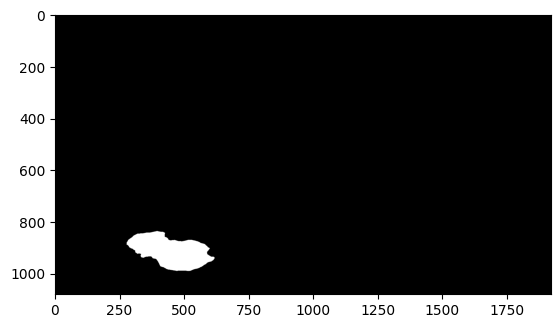

Pothhole Area: 31404 in pixels


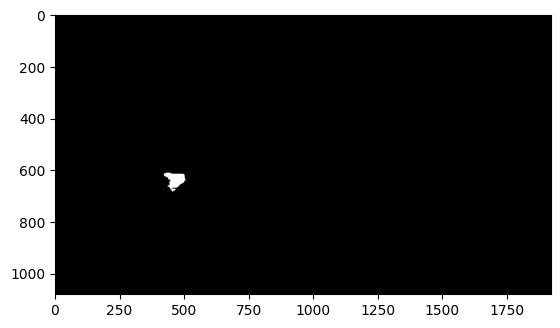

Pothhole Area: 3392 in pixels


In [57]:
for i in range(len(mask)):
    plt.imshow(mask[i,:,:],cmap='gray')
    plt.show()
    print('Pothole Area:',mask[i,:,:].sum(),'in pixels')

In [59]:
mask.shape

(6, 1080, 1920)

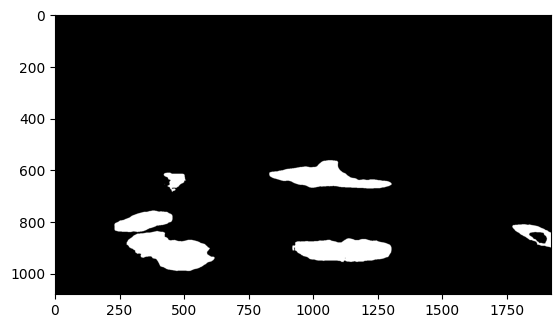

In [62]:
import numpy as np
combined_mask = np.any(mask, axis=0)
binary_mask = combined_mask.astype(np.uint8) * 255
plt.imshow(binary_mask,cmap='gray')

In [ ]:
# Stitch the above logics to work on Video

In [4]:
from ultralytics import SAM, YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load models
sam_model = SAM("sam_b.pt")
pothole_model = YOLO('best.pt')

# Open the video file
video_path = "sections.mov"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fourcc = cv2.VideoWriter_fourcc(*"mp4v")
# out = cv2.VideoWriter("output_video.mp4", fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # YOLO pothole detection on the current frame
    results_pothole = pothole_model(frame, iou=0.3, conf=0.3)

    # Extract bounding boxes if available
    if results_pothole and results_pothole[0].boxes is not None:
        bb = results_pothole[0].boxes.xyxy.data.cpu().numpy().astype(int)
    else:
        bb = np.empty((0, 4), dtype=int)

    # If no bounding boxes detected, simply write the frame
    if bb.shape[0] == 0:
        out.write(frame)
        cv2.imshow("Video", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    # Run SAM segmentation on the frame with the detected bounding boxes
    results_sam = sam_model(frame, bboxes=bb)

    # Get the segmentation masks from SAM
    masks = results_sam[0].masks.data.cpu().numpy()

    # Make a copy of the frame for annotation
    annotated_frame = frame.copy()

    # Loop over each detected pothole
    for i in range(len(masks)):
        # Calculate the area: sum of mask pixels (assuming binary mask: 1 for segmented region)
        area = int(masks[i].sum())

        # Get the corresponding bounding box coordinates
        x1, y1, x2, y2 = bb[i]

        # Draw the bounding box (blue rectangle)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Overlay the area text (green text) above the bounding box
        text = f"Area: {area}"
        cv2.putText(annotated_frame, text, (x1, max(y1 - 10, 10)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Create a colored overlay for the segmentation mask (green overlay)
        colored_mask = np.zeros_like(frame)
        colored_mask[masks[i].astype(bool)] = (0, 255, 0)
        alpha = 0.4  # Transparency factor

        # Blend the colored mask with the annotated frame
        annotated_frame = cv2.addWeighted(colored_mask, alpha, annotated_frame, 1 - alpha, 0)

    # Write the annotated frame to the output video
    out.write(annotated_frame)

    # Optionally, display the frame (press 'q' to quit)
    cv2.imshow("Video", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()



0: 384x640 (no detections), 52.7ms
Speed: 5.4ms preprocess, 52.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 44.1ms
Speed: 4.3ms preprocess, 44.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 43.7ms
Speed: 3.6ms preprocess, 43.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 35.5ms
Speed: 4.1ms preprocess, 35.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 23.4ms
Speed: 3.4ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 23.2ms
Speed: 3.6ms preprocess, 23.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 23.3ms
Speed: 3.0ms preprocess, 23.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 22.1ms
Speed: 3.0ms preprocess, 22.1ms i

In [50]:
# Run inference with single point
# results = model("zidane.jpg",points=[900, 370], labels=[1])
# annotated_image = results[0].plot()
# plt.imshow(annotated_image)
# plt.axis("off")
# plt.show()

In [51]:
# # Run inference with multiple points
# results = model("zidane.jpg",points=[[400, 370], [900, 370]], labels=[1, 1])

# annotated_image = results[0].plot()
# plt.imshow(annotated_image)
# plt.axis("off")
# plt.show()

In [52]:
# # Run inference with multiple points prompt per object
# results = model("zidane.jpg",points=[[[400, 370], [900, 370]]], labels=[[1,1]])
# annotated_image = results[0].plot()
# plt.imshow(annotated_image)
# plt.axis("off")
# plt.show()